# A3

In [1]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import Network as Network
import copy

# Q1: Vanishing Gradient

## (a)

Your answer here.

## (b)

Your answer here.

## (c) Plots

In [5]:
# === YOUR CODE HERE ===

# Q2: Dropout

## Dataset

In [2]:
def GenerateDatasets(n):
    # 1D -> 1D (line mapping)
    n_input = 1
    n_output = 1
    noise = 0.5

    #np.random.seed(452)
    a = np.random.rand()/2.
    m = np.random.rand() + 0.5
    b = np.random.rand()-0.5

    def myfunc(x):
        return a*x**2 + m*x + b

    # Create a training dataset
    n_samples = n
    training_output = []
    training_input = []
    xv = np.linspace(-1, 1, n_samples)
    for idx in range(n_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx]
        t = myfunc(x) + np.random.normal(scale=noise)
        training_input.append(np.array([x]))
        training_output.append(np.array([t]))

    # Create a testing dataset
    test_input = []
    test_output = []
    n_test_samples = 300
    xv = np.linspace(-1, 1, n_test_samples)
    for idx in range(n_test_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx] #+ np.random.normal(scale=0.1)
        t = myfunc(x) + np.random.normal(scale=noise)
        test_input.append(np.array([x]))
        test_output.append(np.array([t]))


    train = [np.array(training_input), np.array(training_output)]
    test = [np.array(test_input), np.array(test_output)]
    
    return train, test

## Sample Code

In [3]:
# Here is an example, creating a Network object.
net = Network.Network(cost='cross-entropy')
net.AddLayer(Network.Layer(1))
net.AddLayer(Network.Layer(6, act='logistic'))
net.AddLayer(Network.Layer(1, act='logistic'))

In [4]:
# Generate the training and testing datasets
P = 5
train, test = GenerateDatasets(P)

In [5]:
# Train the network
progress = net.SGD(train[0], train[1], epochs=100, lrate=1.)

In [6]:
# Evaluate the cost 
print('Training cost = '+str(net.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net.Evaluate(test[0], test[1])))

# These results won't necessarily make sense, since the network model
# might not be the right choice for the dataset.

Training cost = -0.27576196699318956
    Test cost = -0.2879225495717907


## 2 (a), (b), 3 (a) Completing the RobustNetwork Class

In [13]:
class RobustNetwork(Network.Network):
    
    def FeedForward(self, x, dropout=0):
        '''
            y = net.FeedForward(x, dropout=0)

            Runs the network forward, starting with x as input.
            However, a random subset of the hidden nodes are set to 0 activity.
            Returns the activity of the output layer.

            Inputs:
              x is a batch of inputs
              dropout is a probability that a node is dropped, in [0,1]
              
            Outputs:
              y is the batch of outputs (no dropout or the output layer)
        '''
        # X shape: [num_samples, size_of_input_layer]
        
        if dropout==0.:
            self.dropout_nonzero = False  # Internal flag for dropout
            super(RobustNetwork, self).FeedForward(x)
        else:
            self.dropout_nonzero = True   # Internal flag for dropout
            
            x = np.array(x)  # Convert input to array, in case it's not
            
            self.lyr[0].h = x # Set input layer
            
            self.mask = []  # mask will record which nodes were dropped
            self.mask.append(None)  # Input layer does not have dropout
            
            # Save dropout or compute 1/dropout as layer_size/num_active
            self.dropout = dropout
            # Loop over connections
            for pre,post,W in zip(self.lyr[:-1], self.lyr[1:], self.W):
                
                # Calc. input current to next layer
                post.z = pre.h @ W + post.b

                # Use activation function to get activities
                post.h = post.sigma(post.z)
                
                if post == self.lyr[-1]:
                    # Dropout is added only to the hidden layers.
                    continue
                
                # Add dropout for this layer:
                # Dropout will remain constant for a mini-batch.
                # False: Dropped out, True: Contained
                post_mask = np.random.choice([False, True], size=post.N, p=[dropout, 1-dropout])
                self.mask.append(post_mask)
                post.h *= post_mask # post.h.shape = [num_samples, layer_size]

                # Scale input to the next layer
                post.h *= (1./(1. - dropout))
                
                
                
        # Return activity of output layer
        return self.lyr[-1].h
    
    
    
    def BackProp(self, t, lrate=0.05, decay=0.):
        '''
            net.BackProp(targets, lrate=0.05)
            
            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.
            
            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
             decay  is the coefficient for weight/bias decay
        '''
        t = np.array(t)  # convert t to an array, in case it's not
        
        # Error gradient for top layer
        dEdz = self.TopGradient(t)
        
        # Loop down through the layers
        for i in range(self.n_layers-2, -1, -1):
            pre = self.lyr[i]
            
            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz
            
            # Gradient w.r.t. biases
            dEdb = np.sum(dEdz, axis=0)
            
            # Project error gradient down to layer below.
            if i>0:
                # pre.sigma_z_p(pre.z) gives dh/dz not dH/dz (dH = 2*dh) since it calculate logistic()
                if self.dropout_nonzero:
                    # Broadcasting matched the shapes: [num_samples, layer_size]
                    dEdz = ( dEdz @ ((1./(1.-self.dropout)) * self.W[i]).T ) * (pre.sigma_z_p(pre.z) * self.mask[i])
                else:
                    dEdz = ( dEdz @ self.W[i].T ) * pre.sigma_z_p(pre.z)
                    
            
            # Update weights and biases
            self.W[i] -= lrate*dEdW
            self.lyr[i+1].b -= lrate*dEdb
    
    
    def SGD(self, inputs, targets, lrate=0.05, epochs=1, batch_size=10, decay=0, dropout=0):
        '''
            progress = net.SGD(inputs, targets, lrate=0.05, epochs=1, decay=0, dropout=0)

            Performs Stochastic Gradient Descent on the network.
            Run through the dataset in batches 'epochs' number of times, incrementing the
            network weights after each batch. For each epoch, it
            shuffles the dataset.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 5)
              epochs  is the number of times to go through the training data
              decay   is the decay coefficient for the weights and biases
              dropout is the dropout probability
              
            Outputs:
              progress is an (expochs)x2 array with epoch in the first column, and 
                      cost in the second column
        '''
        loss_history = []
        for k in range(epochs):
            batches = Network.MakeBatches(inputs, targets, batch_size=batch_size, shuffle=True)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0], dropout=dropout)
                self.BackProp(mini_batch[1], decay=decay)

            loss_history.append([k, self.Evaluate(inputs, targets)])

        return np.array(loss_history)


## (c) Create the Network

In [56]:
def create_networks():
    original_net = RobustNetwork(cost='MSE')
    original_net.AddLayer(Network.Layer(1))
    original_net.AddLayer(Network.Layer(10, act='arctan'))
    original_net.AddLayer(Network.Layer(1, act='identity'))
    dropout_net = copy.deepcopy(original_net)
    return original_net, dropout_net

original_net, dropout_net = create_networks()

## (d) Train and Evaluate without dropout

In [57]:
def train_and_evaluate(network, train, test, dropout):
    progress = network.SGD(train[0], train[1], epochs=5000, lrate=1., dropout=dropout, batch_size=5)
    print('Training cost = '+str(network.Evaluate(train[0], train[1])))
    test_cost = network.Evaluate(test[0], test[1])
    print('    Test cost = '+str(test_cost))
    return test_cost

train, test = GenerateDatasets(5)
_ = train_and_evaluate(original_net, train, test, dropout=0)

Training cost = 5.93186640307252e-07
    Test cost = 1.2712234601532533


## (e) Train and Evaluate with dropout

In [58]:
_ = train_and_evaluate(dropout_net, train, test, dropout=0.2)

Training cost = 0.2511780613570562
    Test cost = 0.3167635727157567


## (f) Plot training data and models

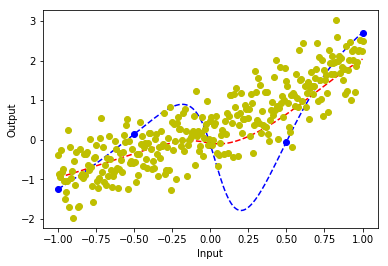

In [59]:
s = np.linspace(-1, 1, 200)
original_output = original_net.FeedForward(np.array([s]).T)
dropout_output = dropout_net.FeedForward(np.array([s]).T)

plt.plot(s,original_output, 'b--')
plt.plot(s,dropout_output, 'r--')
plt.plot(train[0], train[1], 'bo')
plt.plot(test[0], test[1], 'yo')
plt.xlabel('Input')
plt.ylabel('Output');

## (g) Average performance over 10 datasets

In [18]:
test_cost_original, test_cost_dropout = [], []
for i in range(10):
    train, test = GenerateDatasets(5)
    original_net, dropout_net = create_networks()
    test_cost_original.append(train_and_evaluate(original_net, train, test, dropout=0))
    test_cost_dropout.append(train_and_evaluate(dropout_net, train, test, dropout=0.2))
    
print("Mean Test Cost Original Network: %s" % str(np.mean(test_cost_original)))
print("Mean Test Cost Dropout Network: %s" % str(np.mean(test_cost_dropout)))
    

Training cost = 0.004083020597723788
    Test cost = 0.3851081374714896
Training cost = 0.024887773381518343
    Test cost = 0.32569334424918883
Training cost = 0.0006746357474663175
    Test cost = 0.636982181279522
Training cost = 0.029251260366711617
    Test cost = 0.35915669598518574
Training cost = 0.0032705809233301597
    Test cost = 0.4203857233049262
Training cost = 0.04052288085685808
    Test cost = 0.36205850531637923
Training cost = 0.02401146199719461
    Test cost = 0.6603003535349932
Training cost = 0.42687394301216763
    Test cost = 0.35325085095420394
Training cost = 2.835559577636931e-05
    Test cost = 0.3776732351180732
Training cost = 0.06119760522473135
    Test cost = 0.349056807550024
Training cost = 0.00041141331060012024
    Test cost = 0.36733511666385976
Training cost = 0.023879271398146447
    Test cost = 0.28771630170920015
Training cost = 0.006689499380343672
    Test cost = 0.38595271552734045
Training cost = 0.05562224698001672
    Test cost = 0.3102

YOUR ANSWER HERE

# Q3: Weight Decay

## (a) Implement weigth decay in BackProp (see code above)

## (b) Average performance over 10 datasets

In [17]:
# === YOUR CODE HERE ===

YOUR ANSWER HERE

# Q4: Classifier Networks

## Create and interesting dataset

In [18]:
def ClassPlot(x, y):
    # FeedForward
    yc = Network.OneHot(y)
    colour_options = ['y', 'b', 'r', 'g', 'k']
    cidx = np.argmax(yc, axis=1)
    colours = [colour_options[k] for k in cidx]
    plt.scatter(x[:,0],x[:,1], color=colours, marker='.')
    plt.axis('equal');

def GaussianCluster(mu, sa, N, theta=0.):
    theta_rad = theta/180*np.pi
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    R = np.array([[c,-s],[s,c]])
    M = R @ np.diag(sa) @ R.T
    y = np.random.multivariate_normal(mu, M, N)
    return y

def CreateDataset(params):
    '''
        train, test = CreateDataset(params)
        
        Creates a dataset using a bunch of Gaussian clouds.
        
        Inputs:
          params is a list of 5-tuples. Each tuple (or list)
             describes a 2-D Gaussian cloud:
             1) the mean
             2) standard deviation along x and y directions
             3) rotation of cloud (degrees counter-clockwise)
             4) class index
             5) number of points
             
        Outputs:
          train is a list containing 2 arrays
             - the first array contains the training inputs,
               one per row
             - the second array contains the corresponding classes
          test has the same structure as train, but with
               half the number of samples
    '''
    train_inputs = []
    train_outputs = []
    test_inputs = []
    test_outputs = []
    all_c = [p[3] for p in params]
    n_classes = np.max(all_c)
    for p in params:
        xx = GaussianCluster(p[0], p[1], p[4], theta=p[2])
        yy = np.zeros((p[4], n_classes+1))
        yy[:,p[3]] = 1.
        train_inputs.append(xx)
        train_outputs.append(yy)
        xtest = GaussianCluster(p[0], p[1], int(p[4]/2), theta=p[2])
        ytest = np.zeros((int(p[4]/2), n_classes+1))
        ytest[:,p[3]] = 1.
        test_inputs.append(xtest)
        test_outputs.append(ytest)
    train = [np.vstack(train_inputs), np.vstack(train_outputs)]
    test = [np.vstack(test_inputs), np.vstack(test_outputs)]
    return train, test

# 0=y, 1=b, 2=r
params = [[[0.5, 0.5],   [0.025, 0.01],  -45, 0, 50],
          [[-0.5,-0.5],  [0.025, 0.01],  -45, 0, 50],
          [[-0.3,-0.35], [0.04,0.01],     10, 0, 80],
          [[0.6,0],      [0.01,0.01],      0, 0, 50],
          [[0.1,-0.04],  [0.1,0.005],     20, 0, 80],
          [[0.5,-0.5],   [0.02,0.01],     45, 1, 50],
          [[0,0.6],      [0.01,0.01],      0, 1, 50],
          [[-0.5,0.1],   [0.02,0.01],     30, 1, 80],
          [[-0.5,0.5],   [0.02,0.01],     45, 2, 50],
          [[0,-0.6],     [0.01,0.01],      0, 2, 50],
          [[0.2,0.3],    [0.01,0.004],     0, 2, 80],
          [[-0.2,0.37],  [0.02,0.005],   -30, 2, 50],
          [[0.25,-0.3],  [0.005,0.01],     0, 3, 60],
          [[-0.1,0.1],   [0.01,0.01],    -30, 3, 50]
         ]

In [19]:
train, test = CreateDataset(params)

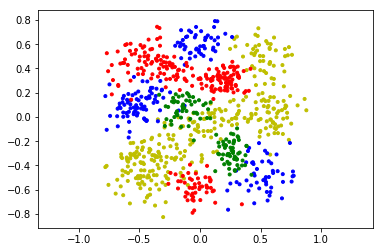

In [20]:
ClassPlot(train[0], train[1]);

## (a) Create and Evaluate a Neural Network

In [21]:
# === YOUR CODE HERE ===

## (b) Evaluate Model

In [22]:
# === YOUR CODE HERE ===

## (c) Crappy Network

In [23]:
# === YOUR CODE HERE ===

In [25]:
# Throw Away Code
np.random.choice([False, True], size=6, p=[0.3, 0.7])

array([ True,  True,  True, False, False,  True])

In [96]:
np.array([[1,2,3],[2,3,4],[10,10,10]])*np.array([20,20,20])

array([[ 20,  40,  60],
       [ 40,  60,  80],
       [200, 200, 200]])